In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import bilby
import emcee
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import ptemcee
from tqdm.notebook import tqdm

In [3]:
logger = bilby.core.utils.logger
outdir = "GW150914-outdir"
label = "GW150914"

In [4]:
trigger_time = 1126259462.4
detectors = ["H1", "L1"]
maximum_frequency = 512
minimum_frequency = 20
roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 4  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

In [5]:
psd_duration = 32 * duration
psd_start_time = start_time - psd_duration
psd_end_time = start_time

In [7]:
ifo_list = bilby.gw.detector.InterferometerList([])
for det in detectors:
    logger.info("Downloading analysis data for ifo {}".format(det))
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    data = TimeSeries.fetch_open_data(det, start_time, end_time, cache=True)
    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time, cache=True)
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
        fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median"
    )
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    ifo_list.append(ifo)

15:07 bilby INFO    : Downloading analysis data for ifo H1
15:07 bilby INFO    : Downloading psd data for ifo H1
15:07 bilby INFO    : Downloading analysis data for ifo L1
15:07 bilby INFO    : Downloading psd data for ifo L1


In [8]:
logger.info("Saving data plots to {}".format(outdir))
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
ifo_list.plot_data(outdir=outdir, label=label)

15:07 bilby INFO    : Saving data plots to GW150914-outdir
15:07 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:07 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2
15:07 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:07 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


In [9]:
priors = bilby.gw.prior.BBHPriorDict(filename="GW150914.prior")

# For some reason the default is not correct!
priors['chirp_mass'] = bilby.core.prior.Uniform(25.0, 35.0, name='chirp_mass', latex_label=r'$\mathcal{M}$')

priors["geocent_time"] = bilby.core.prior.Uniform(
    trigger_time - 0.1, trigger_time + 0.1, name="geocent_time"
)

Apparently the below conversion function is needed for time marginalization: the likelihood needs to know the trigger time in order to compute the detector antenna patterns from the sky location (i.e. it needs to know the relative orientation between the detectors and the source, which requires to know the hour angle of the source).  Somehow the trigger time propagates into the parameters when sampling via `dynesty`, but not `ptemcee`, and I haven't been able to track down the code path that effects that.

In [10]:
def my_convert(theta):
    result, vars = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters(theta)

    if 'geocent_time' not in result.keys():
        result['geocent_time'] = trigger_time
        vars.append('geocent_time')

    return result, vars

waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=my_convert,
    waveform_arguments={
        "waveform_approximant": "IMRPhenomXPHM",
        "reference_frequency": 50,
    },
)

15:08 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: __main__.my_convert


In [11]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list,
    waveform_generator,
    priors=priors,
    time_marginalization=True,
    phase_marginalization=False,
    distance_marginalization=False,
)

In [13]:
sampler = bilby.sampler.Ptemcee(likelihood, priors, outdir=outdir, label=label, 
                                nwalkers=64, ntemps=8, 
                                adapt=True, adaptation_time=10, adaptation_lag=100, Tmax=np.inf,
                                plot=True, Q_tol=1.001, store_walkers=True)

15:08 bilby INFO    : Search parameters:
15:08 bilby INFO    :   mass_ratio = Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
15:08 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
15:08 bilby INFO    :   a_1 = Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None)
15:08 bilby INFO    :   a_2 = Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None)
15:08 bilby INFO    :   tilt_1 = Sine(minimum=0, maximum=3.141592653589793, name='tilt_1', latex_label='$\\theta_1$', unit=None, boundary='reflective')
15:08 bilby INFO    :   tilt_2 = Sine(minimum=0, maximum=3.141592653589793, name='tilt_2', latex_label='$\\theta_2$', unit=None, boundary='reflective')
15:08 bilby INFO    :   phi_12 = Uniform(minimum=0, maximum=6.283185307179586, name='phi_12', latex_label='$\\Delta\\phi$', unit

In [14]:
ptsampler = sampler.setup_sampler()
sampler_kws = sampler.sampler_function_kwargs
pos = sampler.pos0

15:08 bilby INFO    : Generating pos0 samples


## Begin Burnin Loop

Run from here to `End Burnin Loop` repeatedly until you see the mean log-posterior in the cold chain start to go down (initially the trend will be up, as the sampler finds places of high likelihood).  Once you see this, you can transition to the next phase, repeatedly doubling the run length until the autocorrelation function converges.

In [62]:
niter = 128
ptsampler.reset()
for pos, log_post, log_like in tqdm(ptsampler.sample(pos, storechain=True, iterations=niter, **sampler_kws), total=niter):
    pass

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
np.mean(ptsampler.acceptance_fraction, axis=1)

array([0.07373047, 0.05871582, 0.05957031, 0.06311035,
       0.05737305, 0.05908203, 0.0802002 , 0.12072754])

In [ ]:
ptsampler.tswap_acceptance_fraction

array([0.16906738, 0.14904785, 0.11334229, 0.1015625 ,
       0.09246826, 0.08093262, 0.08447266, 0.08654785])

Text(0, 0.5, '$\\beta$')

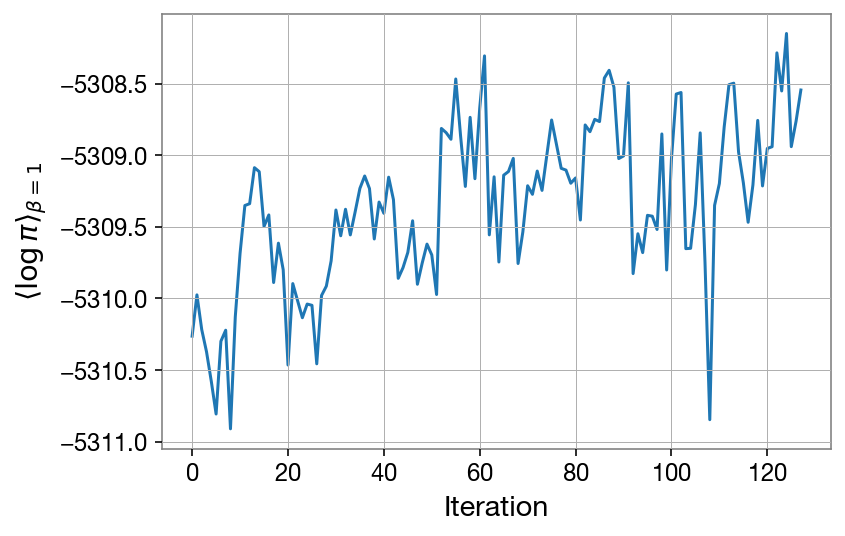

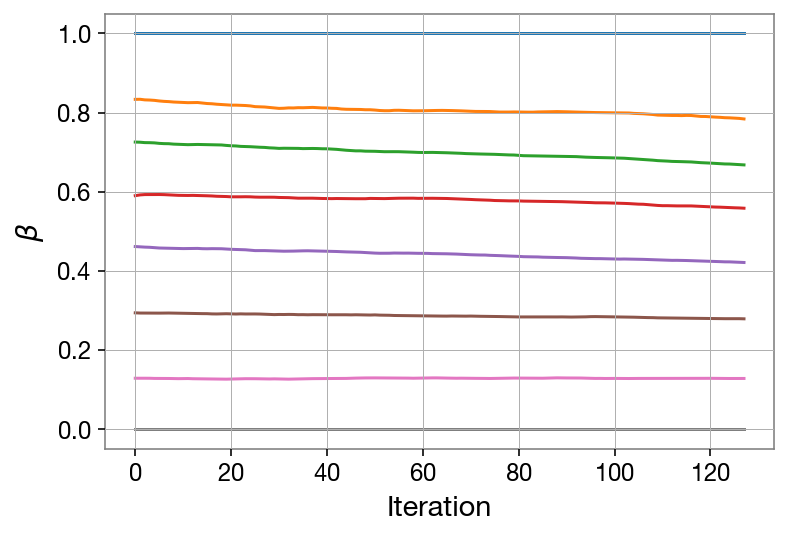

In [ ]:
nt, nw, ns, nd = ptsampler.chain.shape

plt.plot(np.arange(ns), np.mean(ptsampler.logprobability[0,:,:], axis=0))
plt.xlabel(r'Iteration')
plt.ylabel(r'$\left\langle \log \pi \right\rangle_{\beta = 1}$')

plt.figure()
plt.plot(ptsampler.beta_history.T)
plt.xlabel(r'Iteration')
plt.ylabel(r'$\beta$')

In [ ]:
idata = az.convert_to_inference_data({k: ptsampler.chain[0, :, :, i] for (i,k) in enumerate(sampler.search_parameter_keys)})
az.to_netcdf(idata, 'checkpoint.nc')

'checkpoint.nc'

array([[<AxesSubplot:title={'center':'mass_ratio'}>,
        <AxesSubplot:title={'center':'mass_ratio'}>],
       [<AxesSubplot:title={'center':'chirp_mass'}>,
        <AxesSubplot:title={'center':'chirp_mass'}>],
       [<AxesSubplot:title={'center':'a_1'}>,
        <AxesSubplot:title={'center':'a_1'}>],
       [<AxesSubplot:title={'center':'a_2'}>,
        <AxesSubplot:title={'center':'a_2'}>],
       [<AxesSubplot:title={'center':'tilt_1'}>,
        <AxesSubplot:title={'center':'tilt_1'}>],
       [<AxesSubplot:title={'center':'tilt_2'}>,
        <AxesSubplot:title={'center':'tilt_2'}>],
       [<AxesSubplot:title={'center':'phi_12'}>,
        <AxesSubplot:title={'center':'phi_12'}>],
       [<AxesSubplot:title={'center':'phi_jl'}>,
        <AxesSubplot:title={'center':'phi_jl'}>],
       [<AxesSubplot:title={'center':'luminosity_distance'}>,
        <AxesSubplot:title={'center':'luminosity_distance'}>],
       [<AxesSubplot:title={'center':'dec'}>,
        <AxesSubplot:title={'cent

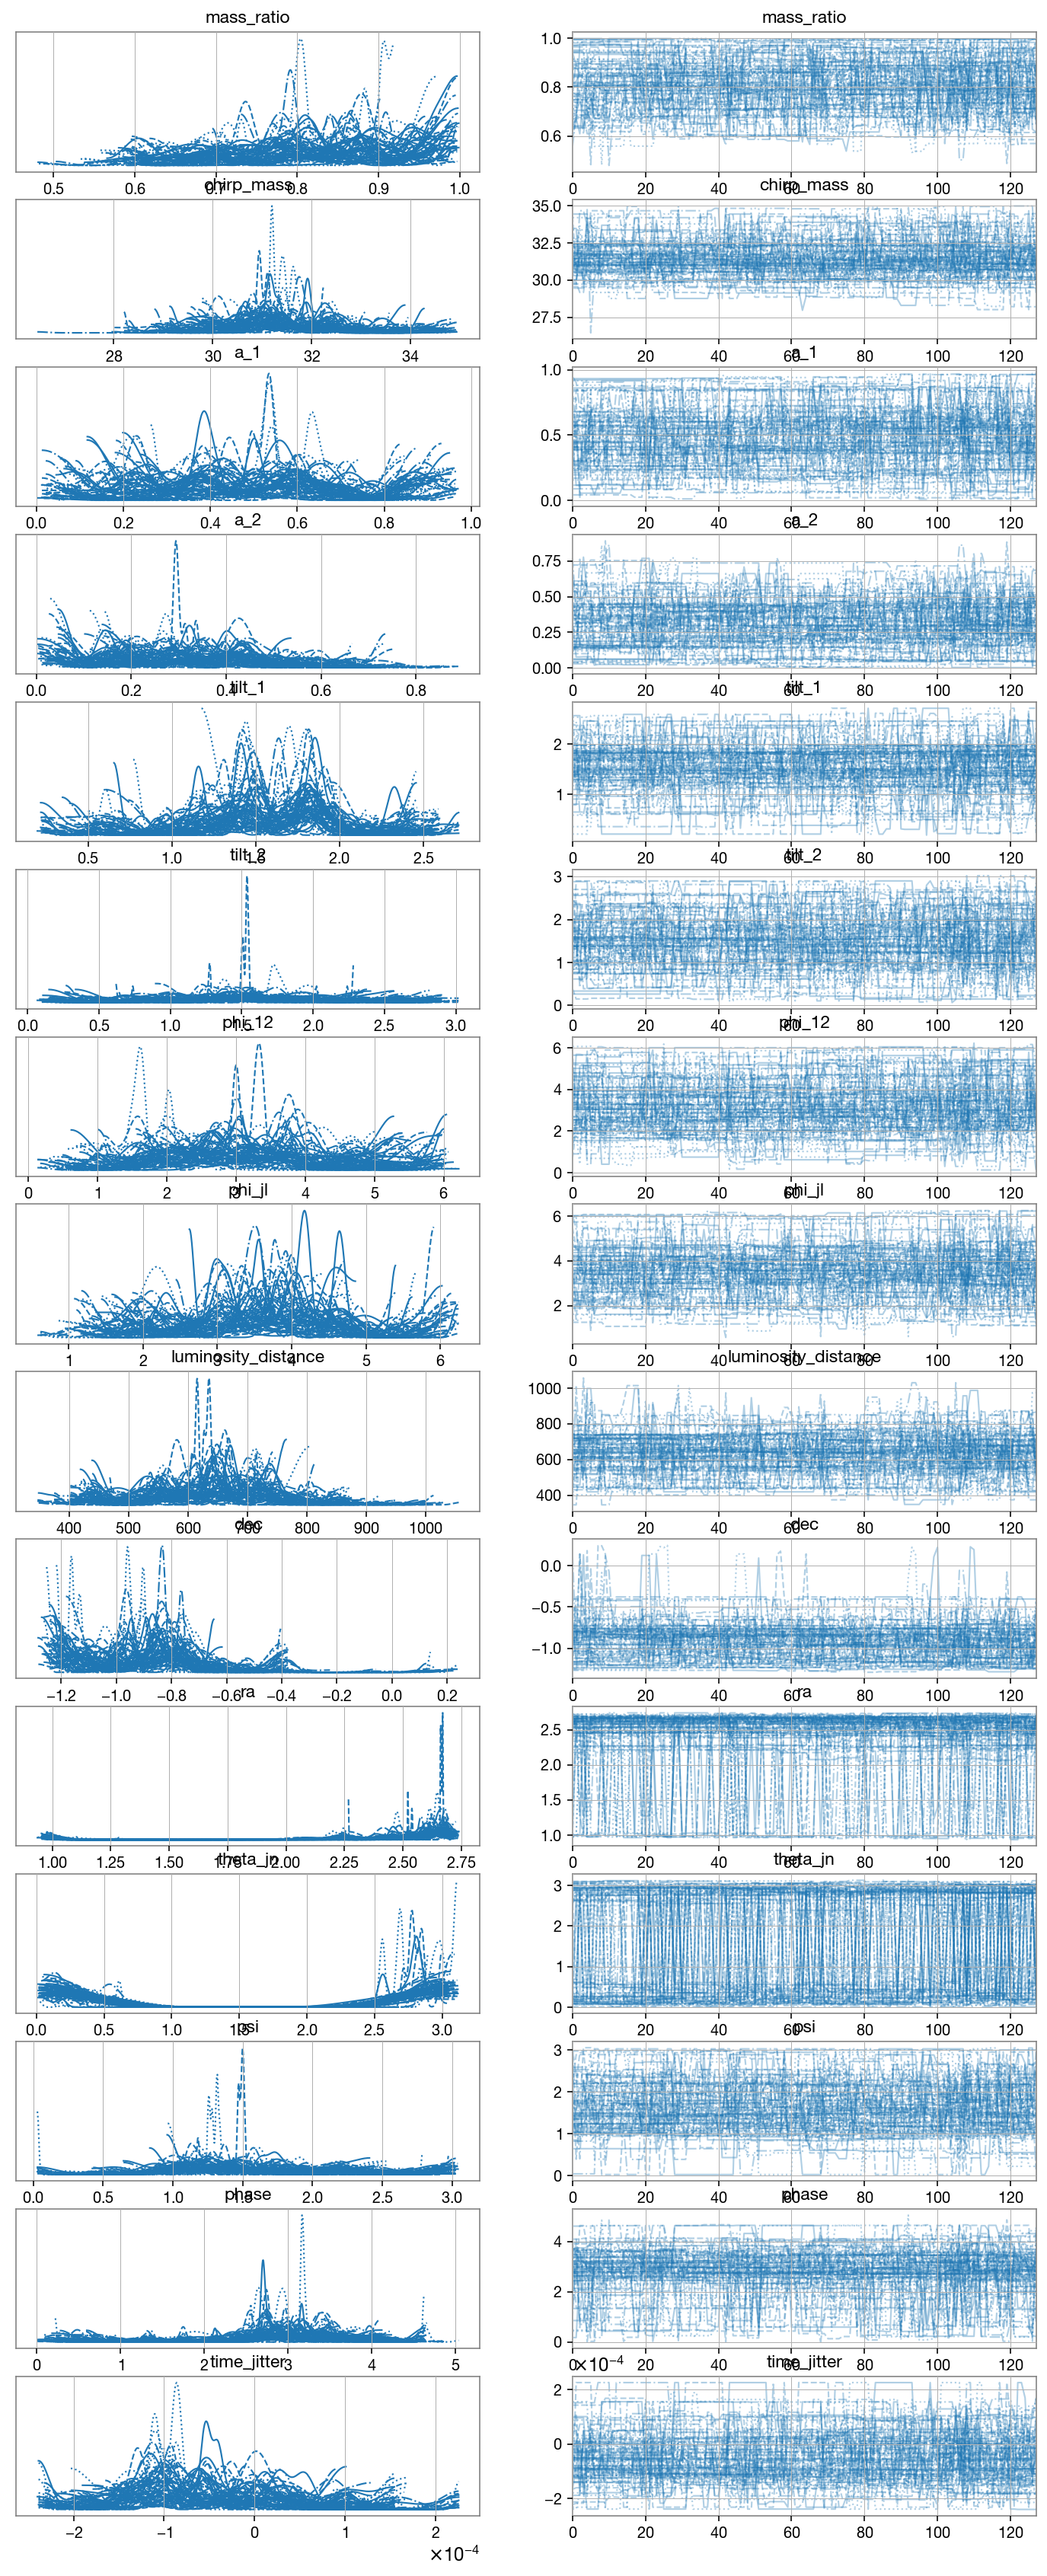

In [ ]:
az.plot_trace(idata)

## End Burnin Loop

## Setup For Sampling Loop

In [151]:
niter = 128
thin = 1

## Begin Sampling Loop

In [180]:
ptsampler.reset()
thin = thin << 1
for pos, log_post, log_like in tqdm(ptsampler.sample(pos, storechain=True, iterations=niter*thin, thin=thin, **sampler_kws), total=niter*thin):
    pass

  0%|          | 0/4096 [00:00<?, ?it/s]

In [181]:
np.mean(ptsampler.acceptance_fraction, axis=1)

array([0.05249405, 0.05153656, 0.04602051, 0.04917908,
       0.03767395, 0.05013657, 0.07801819, 0.12379456])

In [182]:
ptsampler.tswap_acceptance_fraction

array([0.29637909, 0.29811478, 0.29737663, 0.29267311,
       0.27516747, 0.26042557, 0.2598362 , 0.25871277])

Text(0, 0.5, '$\\beta$')

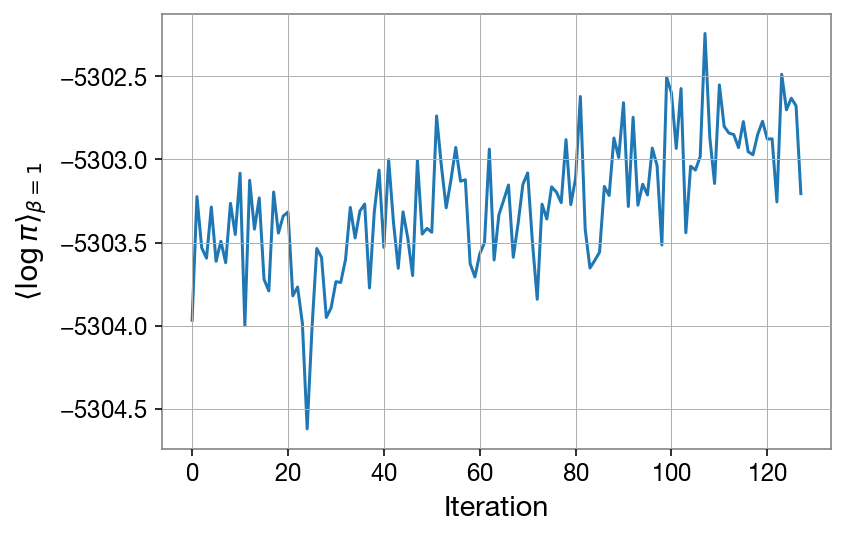

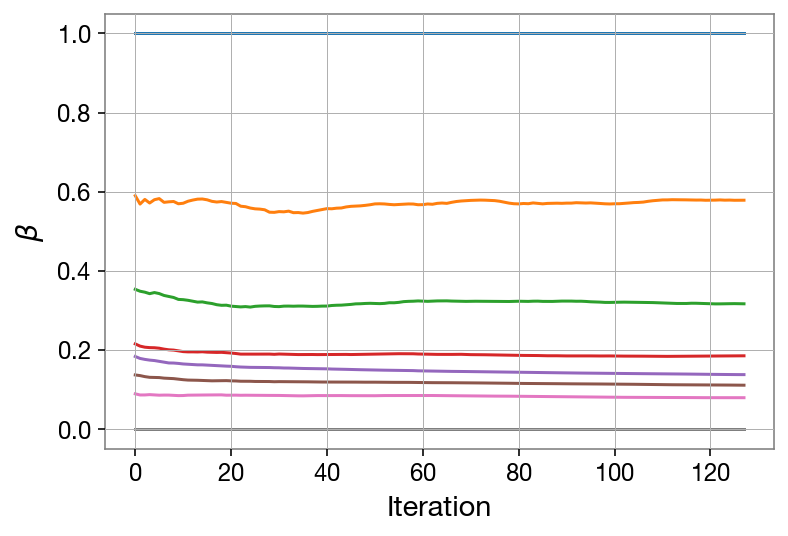

In [183]:
nt, nw, ns, nd = ptsampler.chain.shape

plt.plot(np.arange(ns), np.mean(ptsampler.logprobability[0,:,:], axis=0))
plt.xlabel(r'Iteration')
plt.ylabel(r'$\left\langle \log \pi \right\rangle_{\beta = 1}$')

plt.figure()
plt.plot(ptsampler.beta_history.T)
plt.xlabel(r'Iteration')
plt.ylabel(r'$\beta$')

In [32]:
idata = az.convert_to_inference_data({k: ptsampler.chain[0, :, :, i] for (i,k) in enumerate(sampler.search_parameter_keys)})
az.to_netcdf(idata, 'checkpoint.nc')

'checkpoint.nc'

Let's check out the trace:

array([[<AxesSubplot:title={'center':'mass_ratio'}>,
        <AxesSubplot:title={'center':'mass_ratio'}>],
       [<AxesSubplot:title={'center':'chirp_mass'}>,
        <AxesSubplot:title={'center':'chirp_mass'}>],
       [<AxesSubplot:title={'center':'a_1'}>,
        <AxesSubplot:title={'center':'a_1'}>],
       [<AxesSubplot:title={'center':'a_2'}>,
        <AxesSubplot:title={'center':'a_2'}>],
       [<AxesSubplot:title={'center':'tilt_1'}>,
        <AxesSubplot:title={'center':'tilt_1'}>],
       [<AxesSubplot:title={'center':'tilt_2'}>,
        <AxesSubplot:title={'center':'tilt_2'}>],
       [<AxesSubplot:title={'center':'phi_12'}>,
        <AxesSubplot:title={'center':'phi_12'}>],
       [<AxesSubplot:title={'center':'phi_jl'}>,
        <AxesSubplot:title={'center':'phi_jl'}>],
       [<AxesSubplot:title={'center':'luminosity_distance'}>,
        <AxesSubplot:title={'center':'luminosity_distance'}>],
       [<AxesSubplot:title={'center':'dec'}>,
        <AxesSubplot:title={'cent

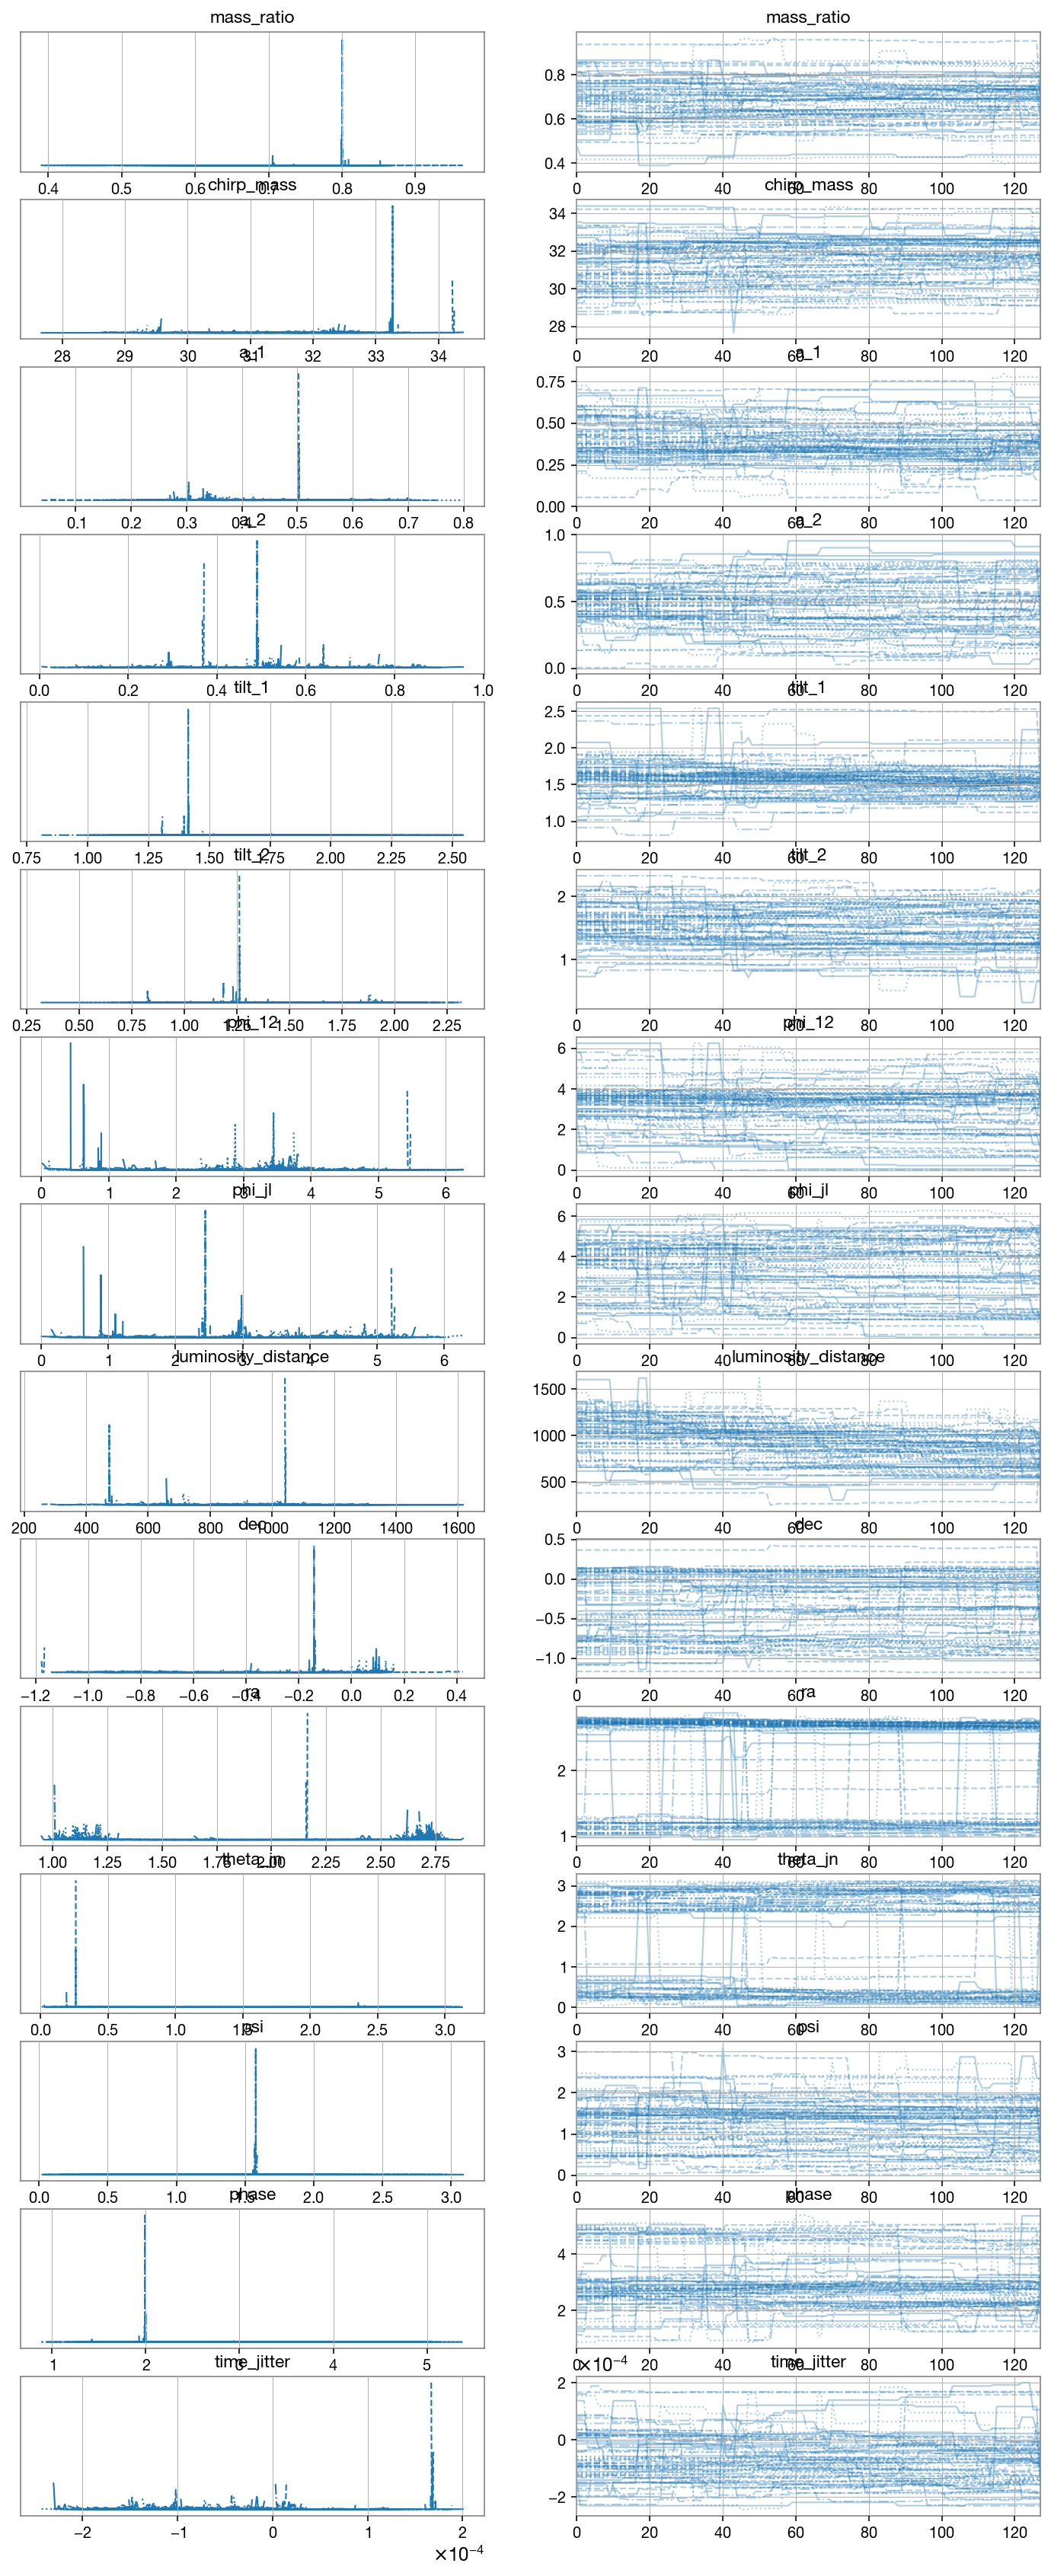

In [33]:
az.plot_trace(idata)

In [186]:
taus = emcee.autocorr.integrated_time(ptsampler.chain[0,...].transpose((1,0,2)))
taus

array([0.9563245 , 0.94217421, 0.9398788 , 0.99167974,
       0.88084561, 0.98708081, 1.03122416, 1.14940381,
       1.02247529, 0.97894154, 1.01998856, 0.95410909,
       0.98020224, 0.92657001, 0.99291721])

If the above ACT computation succeeds, then the chain is long enough to be burned in, and you can exit the loop; otherwise go back to the top and run it again.

## Sampling Loop End